In [48]:
!python -m pip install typing_extensions
!python -m pip install types_networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 2.7 MB/s eta 0:00:00


In [2]:
from __future__ import annotations

from typing_extensions import Self
from typing import Set, Dict, List, Tuple, NewType, Optional, Callable, Any, TYPE_CHECKING

if TYPE_CHECKING:
    from types_networkx import DiGraph

import matplotlib.pyplot as plt
import numpy

# Analyzing citation networks
This task involves exploring the High-energy physics citation network. Arxiv HEP-PH (high energy physics phenomenology) citation graph is from the e-print arXiv and covers all the citations within a dataset of 34,546 papers with 421,578 edges. If a paper $i$ cites paper $j$, the graph contains a directed edge from $i$ to $j$. If a paper cites, or is cited by, a paper outside the dataset, the graph does not contain any information about this. This dataset is temporal, which means the structure of the network changes over time as new academic papers are published.

Dataset link: [http://snap.stanford.edu/data/cit-HepPh.html]()

In [3]:
# Downloading dataset
!mkdir -p data
!curl "http://snap.stanford.edu/data/cit-HepPh.txt.gz" > data/citations.txt.gz
!curl "http://snap.stanford.edu/data/cit-HepPh-dates.txt.gz" > data/citations-date.txt.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1625k  100 1625k    0     0  1928k      0 --:--:-- --:--:-- --:--:-- 1928k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96569  100 96569    0     0   324k      0 --:--:-- --:--:-- --:--:--  325k


In [4]:
# Unzipping data
!gzip --decompress --stdout data/citations.txt.gz > data/citations.txt
!gzip --decompress --stdout data/citations-date.txt.gz > data/citations-date.txt

# Task 1: A graph exploration task
The first task is a graph exploration task. Build out a graph from the dataset given, and record how the graph and its properties change over time. You are expected to perform this task on at least 5 properties, and report iteresting insights. Few simple properties include different types of centrality, density, and diameter. This task is focused on exploratory data analysis, and you are expected to show plots and metrics to support your findings.

In [5]:
!python -m pip install networkx

In [6]:
import networkx as nx

Instead of building the graph straight out, we first sort papers by authorship date.

In [7]:
from datetime import date, timedelta

def parse_date (date_str: str, date_sep: str = '-'):
    return date(*[int(x) for x in date_str.split(date_sep)])

In [8]:
PaperId = NewType('PaperId', int)

In [9]:
from dataclasses import dataclass

@dataclass
class Paper:
    index: int = 0
    date: date = date(1970, 1, 1)
    days_since_epoch: int = 0 # Required for feature extraction
    arxiv_id: PaperId = PaperId(0)
    correct_arxiv_id: PaperId = PaperId(0)
    ignored: bool = False
    cross_referenced: bool = False
    csr_matrix = None

In [10]:
comment_filter = lambda x: x[0] != '#'

arxiv_papers: List[Paper] = []
counter = 0

# The edge list stores indices of the papers in the paper list. This will make
# it easier to lookup the required paper while minimising space required in the
# actual graph
edge_list: List[Tuple[int, int]]= []

EPOCH = date(1970, 1, 1)

with open("data/citations.txt") as graph, open('data/citations-date.txt') as dates:
    # Read and parse publication dates for each paper
    for line in filter(comment_filter, dates):
        paper: List[str] = line.split()
        new_paper: Paper = Paper()
        new_paper.arxiv_id = PaperId(int(paper[0]))
        new_paper.correct_arxiv_id = new_paper.arxiv_id

        # Cross referenced paper found. Deal with it appropriately
        if paper[0][:2] == '11':
            new_paper.correct_arxiv_id = PaperId(int(paper[0][2:]))
            new_paper.cross_referenced = True

        new_paper.date = parse_date(paper[1])
        new_paper.days_since_epoch = (new_paper.date - EPOCH).days

        arxiv_papers.append(new_paper)

    for i in range(len(arxiv_papers)):
        arxiv_papers[i].index = i

    arxiv_paper_lookup: Dict[PaperId, Paper] = {paper.correct_arxiv_id: paper for paper in arxiv_papers}

    # Now, filter all edges according to date
    for edge in filter(comment_filter, graph):
        edge_data: List[int] = [int(x) for x in edge.split()]

        has_ignored_papers: bool = False
        for paper in edge_data:
            if paper not in arxiv_paper_lookup.keys():
                has_ignored_papers = True

        if not has_ignored_papers:
            edge_list.append(tuple([arxiv_paper_lookup[y].index for y in edge_data]))

Since the graph is large, we only sample a section of it.

In [11]:
# alpha: probability of considering edge
alpha = 0.2

In [12]:
citations_with_time: DiGraph = nx.DiGraph()

for paper in arxiv_papers:
    citations_with_time.add_node(paper.index, date=paper.days_since_epoch)

import numpy as np
rng = np.random.default_rng(seed=42)

for edge in edge_list:
    # actualy insert edge into network
    if rng.random() < alpha:
        citations_with_time.add_edge(*edge, date=max([arxiv_papers[e].days_since_epoch for e in edge]))

In [13]:
np.isclose(citations_with_time.size() /  len(edge_list), alpha, rtol=1e-2)

True

Hence, the sampling is reasonably accurate. We can now use this graph to perform the rest of our analysis

In [14]:
citations_with_time.size()

69557

There are some paper ids that are not present in the publication dataset, and therefore we will ignore those paper ids. Additionally, there seem to be some papers that don't cite or are cited, which must indicate citations outside the network. We can verify this finding by picking a random sample of such papers and looking at the actual Arxiv papers

In [56]:
def build_graph_over_time (callback_function: Callable[[Digraph, int, int], Any], skip_days: int) ->  Dict[int, Any]:
    # Borrowed from: https://stackoverflow.com/questions/42856659/how-to-sort-edges-in-networkx-based-on-their-weight
    edges = sorted(citations_with_time.edges(data=True), key=lambda edge: edge[2].get('date', 0))
    # Make it easier to insert data
    edges: List[Tuple[int, Tuple[PaperId, PaperId]]] = [(e[2].get('date', 0), (e[0], e[1])) for e in edges if e[0] != e[1]]

    temporal_graph: DiGraph = nx.DiGraph()
    curr_date: int = 0
    prev_date: int = 0
    result: Dict[int, Any] = {}
    for edge in edges:
        # Iterate through all the edges, and see when have we changed the date
        if curr_date < edge[0]:
            print(f"Old date: {curr_date}", end="\r")
            if (curr_date - prev_date) > skip_days:
                result[curr_date] = callback_function(temporal_graph, curr_date, edge[0])
                prev_date = curr_date
            curr_date = edge[0]

        temporal_graph.add_edge(*edge[1], date = curr_date)

    return result

## Number of citations over papers
The number of citations (# of edges) appears to increase linearly.

In [59]:
citations = build_graph_over_time(lambda graph, _old, _new: (len(graph.edges()), len(graph.nodes())), 10)

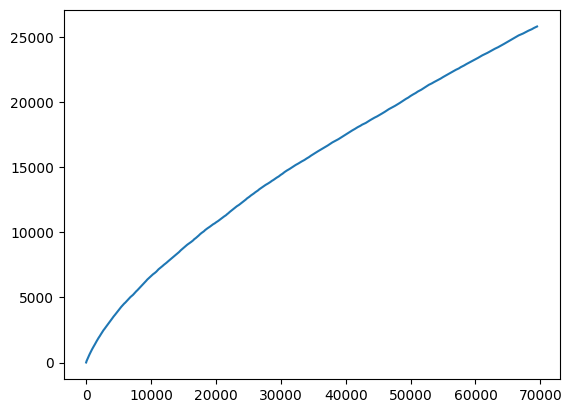

In [61]:
plt.plot(*zip(*citations.values()))
plt.show()

The number of papers seems to be proportional to the number of citations. This goes against Metcalfe's "law", which states that the value of a network (in this case, the number of citations) is directly prportional to the number of participants in it (here, the number of paper). Interestingly, this would also mean that the **average number of citations** remains roughly the same, despite the rapid increase in popularity of Arxiv.

# Degree Assortativity Coefficient of the graph
Assortativity measures the similarity of connections in the graph with respect to the node degree.

In [86]:
dac = build_graph_over_time(lambda graph, _old, _new: nx.degree_assortativity_coefficient(graph), 30)

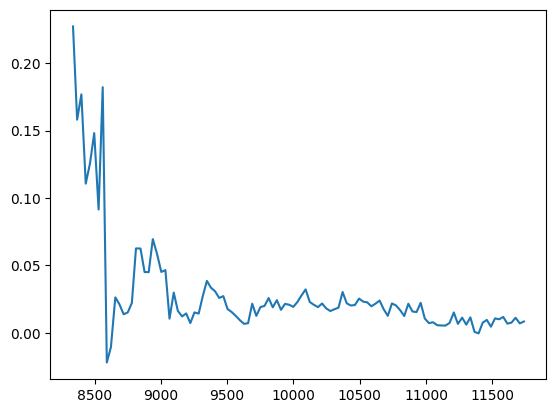

In [87]:
plt.plot(dac.keys(), dac.values())

Clearly, as more papers are added, there is less and less dependecies on the degree of the graph. This shows that there is little similarlty between them.

# Degree centrality
A rather simple metric, this hypothises that the centremost node is the most central one.

In [72]:
degree_centrality = build_graph_over_time(lambda graph, _old, _new: nx.degree_centrality(graph), 30)

In [81]:
max_degree_centrality = [max(val) for val in degree_centrality.values()]

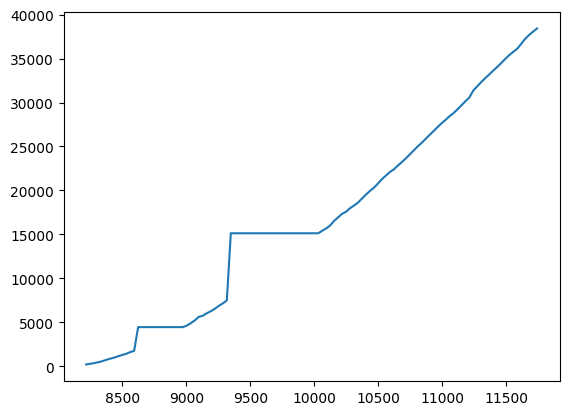

In [83]:
plt.plot(degree_centrality.keys(), max_degree_centrality)

Naturally, as time increases, the number of citations also increases for the most cited paper in the dataset.

## PageRank

PageRank, termed as the 'Billion Dollar algorithm', attempts to calculate the influence of a vertex on the graph by taking random walks through the graph. Improving over Katz centrality, it prevents inflating ranks of neighbours of influential vertices in the graph (here, the papers cited by influential papers).

In [16]:
pagerank = nx.pagerank(citations_with_time)

In [17]:
pagerank_papers = {str(key): val for key, val in zip(pagerank.keys(), pagerank.values())}

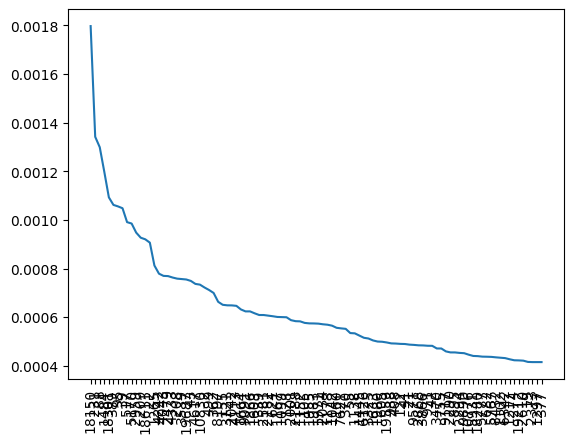

In [18]:
imp_papers = sorted(pagerank_papers.items(), reverse = True, key = lambda x: x[1])[:100]
plt.xticks(rotation=90)
plt.plot(*zip(*imp_papers))
plt.show()

In isolation, this might appear useless. Let us also look at the number of citations each paper in this list gets, and compare it with the maximum number of citations it receives

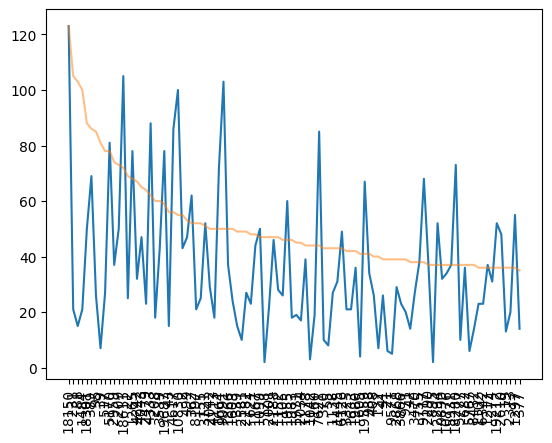

In [19]:
imp_paper_citations = [(node[0], citations_with_time.in_degree(int(node[0]))) for node in imp_papers]

paper_citations = [citations_with_time.in_degree(node) for node in citations_with_time.nodes()]
most_cited_papers = sorted(paper_citations, reverse=True)[:100]

plt.xticks(rotation=90)
plt.plot(*zip(*imp_paper_citations))
plt.plot(most_cited_papers, alpha = 0.5)
plt.show()

It is clear that citations does not imply influence, and it is merely a weak indicator at best. Some of the most influential papers, according to PageRank, have less than 100 citations. It is interesting, however, to note some of the papers which have received a high PageRank score despite low number of citations. Clearly, the number of citations is merely a sign of weak correlation with importance regarded to it via PageRank

In [20]:
low_citations_high_impact = list(filter(lambda x: x[1] < 100, imp_paper_citations))

# Task 2: Clustering in graphs
Community detection or clustering is an important analysis for graphs. In
the study of complex networks, a network is said to have community structure if
the nodes of the network can be easily grouped into disjoint sets of nodes such
that each set of nodes is densely connected internally, and sparsely between
different communities. In this task, you are required to perform community
detection on the graph. This is a well studied problem, and various static
algorithms as well as machine learning methods exist for community detection.
You are required to:
1. Implement any two algorithms/ ML methods for community detection on the graph at any time $T$
2. Analyze the communities (Can you build an understanding of why the algorithm chose the communities it did?)
3. Perform temporal community detection, through which you can study how communities evolve over time as new papers are added. Report interesting insights using various plots and metrics

## Algorithm 1: Infomap
Infomap is a recent algorithm that uses the map equation to see how the network carries flow. This is done by assigning codewords to the nodes to determine an optimal compression of the network that corresponds to the communities in the network.

In [ ]:
!python -m pip install cdlib infomap pyclustering wurlitzer

In [22]:
import cdlib.algorithms as alg
from cdlib import viz

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg'}


In [23]:
communities_overall = alg.infomap(citations_with_time)

In [ ]:
def infomap_callback (graph, _old, _curr):
    communities = alg.infomap(graph)
    return communities

communities_over_time = build_graph_over_time(infomap_callback, 30)

In [156]:
communities_overall.get_description()

'Infomap()'

# Algorithm 2: DeepWalk

In [ ]:
!pip install karateclub

In [26]:
from karateclub.node_embedding.neighbourhood import DeepWalk

model = DeepWalk()
model.fit(citations_with_time)

In [27]:
embeddings = model.get_embedding()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming your high-dimensional embeddings are stored in a numpy array called 'embeddings'
# embeddings.shape should be (num_embeddings, embedding_dimension)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

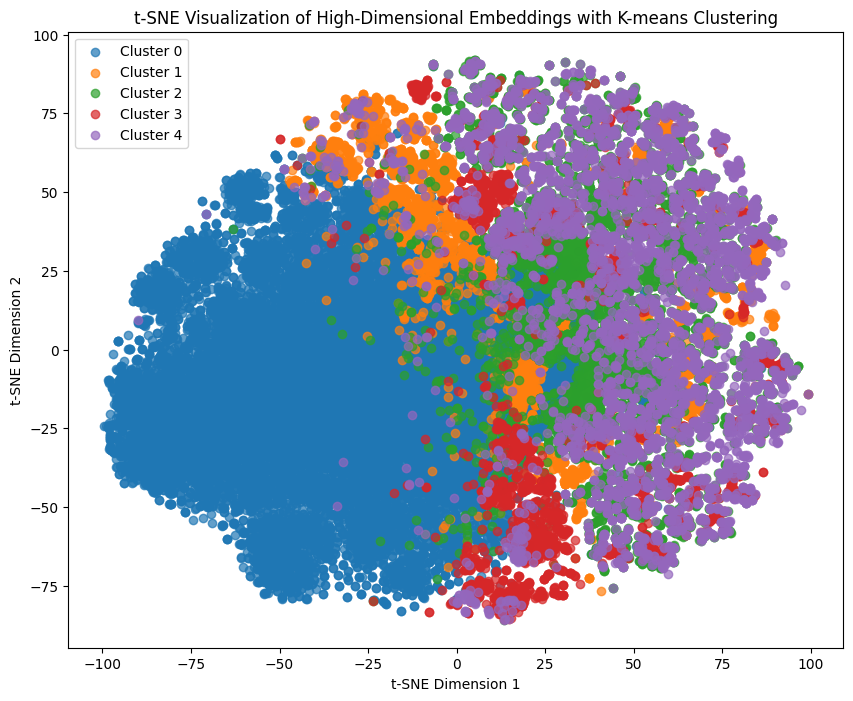

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(embeddings)

# Plot the 2D embeddings with different colors for each cluster
plt.figure(figsize=(10, 8))
for cluster_label in set(cluster_labels):
    plt.scatter(embeddings_2d[cluster_labels == cluster_label, 0],
                embeddings_2d[cluster_labels == cluster_label, 1],
                label=f'Cluster {cluster_label}', alpha=0.7)
plt.title('t-SNE Visualization of High-Dimensional Embeddings with K-means Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

From the t-SNE visualisation, it appears that the communities are overlapping each other quite significantly. Papers that are in multiple clusters, therefore, must have some interesting properties. Let us take a look.


In [42]:
!pip install umap-learn==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 992.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.4.0-py3-none-any.whl size=66134 sha256=95e5e02d700a781f2356e357914a431621cbf6ed50bc0d169c1e4ff30d5c2cb7
  Stored in directory: /root/.cache/pip/wheels/d2/fb/4a/99df9ff3aad803c645cce5a3eb188039a48624d46d40470fde
Successfully built umap-learn
  Attempting uninstall: umap-learn
    Found existing installation: umap-learn 0.5.0
    Uninstalling umap-learn-0.5.0:
      Successfully uninstalled umap-learn-0.5.0


In [45]:
%load_ext autoreload
%autoreload 2

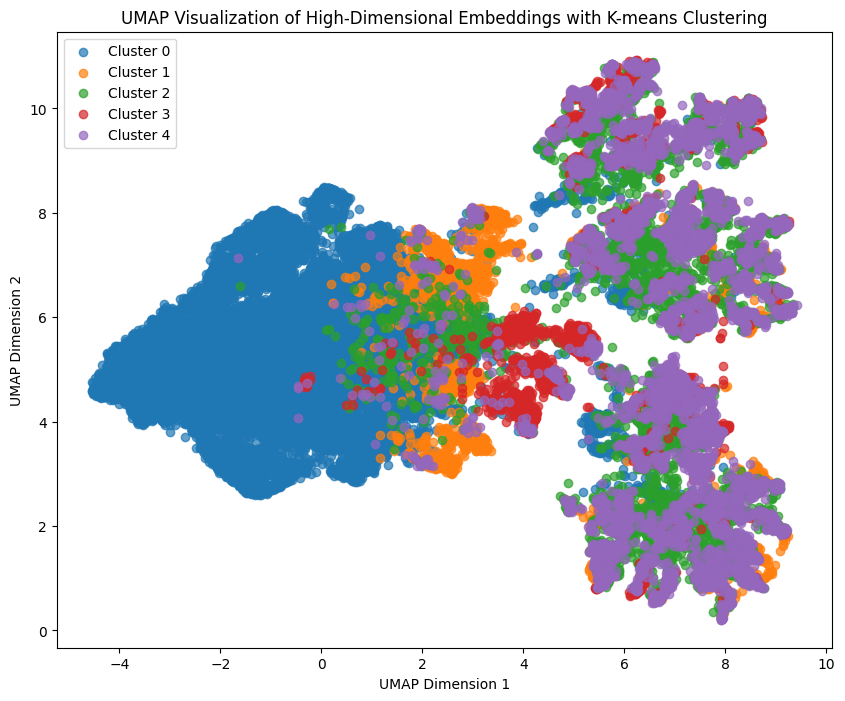

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import KMeans

# Assuming your high-dimensional embeddings are stored in a numpy array called 'embeddings'
# embeddings.shape should be (num_embeddings, embedding_dimension)

# Perform UMAP dimensionality reduction
umap = UMAP(n_components=2, random_state=42)
embeddings_2d_umap = umap.fit_transform(embeddings)

# Cluster the embeddings using K-means
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(embeddings)

# Plot the 2D embeddings with different colors for each cluster
plt.figure(figsize=(10, 8))
for cluster_label in np.unique(cluster_labels):
    plt.scatter(embeddings_2d_umap[cluster_labels == cluster_label, 0],
                embeddings_2d_umap[cluster_labels == cluster_label, 1],
                label=f'Cluster {cluster_label}', alpha=0.7)
plt.title('UMAP Visualization of High-Dimensional Embeddings with K-means Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()


# Bonus Task: Link Prediction
Link Prediction is a task in graph and network analysis where the goal is to predict missing or future connections between nodes in a network. As before, multiple algorithms exist for this task. However, you are required to implement both a graph neural network, and a classic algorithm like DeepWalk or Node2Vec. For training, you can use the citation network at any time interval $[0, T]$ and for testing/validation, use nodes that appear after time $T$. Compare the results of the two approaches, and analyze whether the GNN performs better, and if so, why. You will be evaluated on how well the model can predict these edges, as well as your understanding of the link prediction task in the graph.

In [48]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00


---

Improvements that I didn't get time for:
1. Instead of ignoring nodes without dates, we could try and predict the dates, and then compare that with the actual dates using the Arxiv API. Naturally, this could also extend to other features of papers, including authors and title, if not entire pdfs.
2. We could look at the authors for each paper in the community. This will allow for interesting analytics. For example, do authors tend to cite their own papers more often? The natural answer to this seems to be yes, since the greatest challenge to citations is discoverability, after the clarity of the paper itself. Other questions that we could explore are:
  - Is there any correlation between communities of papers and authors?
  - Are there citation cartels, where people cite each other to inflate citation numbers? This could be important to uncover scientific fraud.